<a href="https://colab.research.google.com/github/zbooster/Antenna-Performance-Prediction/blob/main/RF_Baseline_using_Splitdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 기본설정

### 한글설정

In [1]:
!apt-get install fonts-nanum* > /dev/null 2>&1
!fc-cache -fv > /dev/null 2>&1

In [2]:
import os
import matplotlib as mpl

file_dir = os.path.split(mpl.__file__)[0]
font_dir = os.path.join(file_dir, 'mpl-data/fonts/ttf')
!cp /usr/share/fonts/truetype/nanum/Nanum* {font_dir}
!rm -rf ~/.cache/matplotlib/*

In [3]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 5.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


> Runtime Restart

In [1]:
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumGothicCoding')

### 데이터 가져오기

In [2]:
import os
import gdown
import glob
import pandas as pd
from collections import defaultdict

id = "10Hpa4YM0KX_Ig0W9w7DbTdq62nF2UThA"
output = "./open.zip"

if not os.path.isdir('./datasets'):
  gdown.download(id=id, output=output)
  gdown.extractall(path=output, to='./datasets')

raw_data = defaultdict(pd.DataFrame)

for fname in glob.glob('/content/datasets/**/*.csv', recursive=True):
    df_name = os.path.splitext(os.path.basename(fname))[0]
    raw_data[df_name] = pd.read_csv(fname)

Downloading...
From: https://drive.google.com/uc?id=10Hpa4YM0KX_Ig0W9w7DbTdq62nF2UThA
To: /content/open.zip
100%|██████████| 10.0M/10.0M [00:00<00:00, 88.1MB/s]


### 라이브러리 불러오기

In [3]:
import seaborn as sns
import numpy as np

from collections import defaultdict

from sklearn import metrics
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from statsmodels.tsa.holtwinters import ExponentialSmoothing

## 함수 선언

In [21]:
# 데이콘에서 제공한 평가함수
def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(0,14): # ignore 'ID'
        rmse = metrics.mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:14])
    return score

# 변경한 함수
def single_nrmse(gt, preds):
    rmse = metrics.mean_squared_error(gt, preds, squared=False)
    nrmse = rmse/np.mean(np.abs(gt))
    return nrmse

# 상관관계 높은 컬럼 리스트 반환
def get_correlation_columns(data, cname):
  co_data = data.filter(regex='X|{}'.format(cname)).copy()

  pipe = Pipeline(steps=[
    ('preprocessing', MinMaxScaler())
  ])

  trans = pd.DataFrame(columns=co_data.columns, data=pipe.fit_transform(co_data)).copy()

  cm = co_data.corr().abs().round(3)
  result = cm.iloc[-1:].drop(columns=cname).copy()
  result = result.sort_values(by=cname, axis=1, ascending=False).copy()
  return result.columns[:len(co_data.columns)//2].to_list()

def display_all_X(data):
  print('data size: {}'.format(len(data)))
  plot_rows = len(data.columns) // 5 + 1
  plot_columns = 5

  fig, ax = plt.subplots(plot_rows, plot_columns, figsize=(20, 4 * plot_rows))

  for i, cname in enumerate(data.columns):
    sns.histplot(x=cname, data=data, ax=ax[i//5][i%5])
    
  plt.show()

def winsorize_y(data, cname):

  y_info = raw_data['y_feature_spec_info'].copy()
  _, s_min, s_max = y_info[y_info['Feature'] == cname].values[0]

  data['Status'] = 'Normal'
  data.loc[(data[cname] < s_min) | (data[cname] > s_max), ['Status']] = 'Error'

  s_mean = np.mean([s_min, s_max])
  data['_abs'] = data[cname] - s_mean
  data['_abs'] = data['_abs'].abs()
  data['_rank'] = data['_abs'].rank(ascending=False)
  rank_limit = len(data[data['Status']=='Error']) * 0.2
  data.loc[data['_rank'] < rank_limit, ['Status']] = 'Outlier'
  e_min = data[data['Status']=='Error'][cname].min()
  e_max = data[data['Status']=='Error'][cname].max()
  data.loc[(data[cname] < e_min), [cname]] = e_min
  data.loc[(data[cname] > e_max), [cname]] = e_max
  
  return data.filter(regex='Y').copy()

def split_patten(data):
  start_idx, data_size = 0, len(data)
  result = []
  for i in range(data_size):
    if i < 10 or i > data_size - 10:
      pass
    elif (data['X_30'][i-5:i] < 1.425).all() and (data['X_30'][i:i+5] > 1.425).all():
      result.append(i-start_idx)
      start_idx = i
    elif (data['X_26'][i:i+5] == 2.03).all() and (data['X_27'][i:i+5] == 2.07).all() \
        and len(result) >= 5 and (i - start_idx > 1000):
      result.append(i-start_idx)
      start_idx = i
  else:
    result.append(data_size-start_idx)
  return result

def time_data(data):
  T_dict = {'T_SIN':[], 'T_COS':[]}

  for size in split_patten(data):
    T_dict['T_SIN'].extend([ np.sin(2 * np.pi * i/size) for i in range(size) ])
    T_dict['T_COS'].extend([ np.cos(2 * np.pi * i/size) for i in range(size) ])

  return pd.DataFrame(T_dict).copy()

def outlier_index(data, sigma=3):
  data = data.abs()
  min_index = data.index[0]
  SF = data.values.std() * sigma

  model = ExponentialSmoothing(data, 
                               trend='additive', 
                               seasonal_periods=len(data)//6,
                               initialization_method=None)
  model = model.fit()

  prediction = model.predict(
      start=data.index[0], end=data.index[-1]
  )

  result = []
  for idx, (actual, predicted) in enumerate(zip(data.values, prediction)):
    if predicted - SF < actual < predicted + SF:
      pass
    else:
      result.append(min_index + idx)

  return result

def winsorize_value(data, sigma=3):
  sign = (-1 if data.mean()[0] < 0 else 1)
  data = data.abs()
  min_index = data.index[0]
  SF = data.values.std() * sigma

  model = ExponentialSmoothing(data, 
                               trend='additive', 
                               seasonal_periods=len(data)//6,
                               initialization_method=None)
  model = model.fit()

  prediction = model.predict(
      start=data.index[0], end=data.index[-1]
  )

  result = []
  for actual, predicted in zip(data.values, prediction):
    if actual < predicted - SF: 
      result.append(sign * round(predicted - SF, 3))
    elif actual > predicted + SF: 
      result.append(sign *round(predicted + SF, 3))
    else:
      result.append(sign *actual[0])

  return result

## 데이터 전처리

In [5]:
train_raw = raw_data['train'].copy()
train_raw = train_raw.drop(columns=['X_04', 'X_23', 'X_47', 'X_48']).copy()
train_raw = train_raw.drop(columns=['X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56']).copy()

test_raw = raw_data['test'].copy()
test_raw = test_raw.drop(columns=['X_04', 'X_23', 'X_47', 'X_48']).copy()
test_raw = test_raw.drop(columns=['X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56']).copy()

T_train = time_data(train_raw)
train_raw = train_raw.join(T_train)

T_test = time_data(test_raw)
test_raw = test_raw.join(T_test)

# 스펙이 아웃되는 불량 데이터는 Spec 최대/최소 값으로 수정
y_info = raw_data['y_feature_spec_info'].copy()
for cname in ['Y_%02d' % (i+1) for i in range(14)]:
  if cname == 'Y_06':
    train_raw[cname] = train_raw[cname].abs()

# train/test 데이터를 패턴에 따라 2개로 나눔
train_index = [(0, 13912), (13912, 39607)]
test_index = [(0, 13516), (13516, 39608)]

### 시간변수 추가

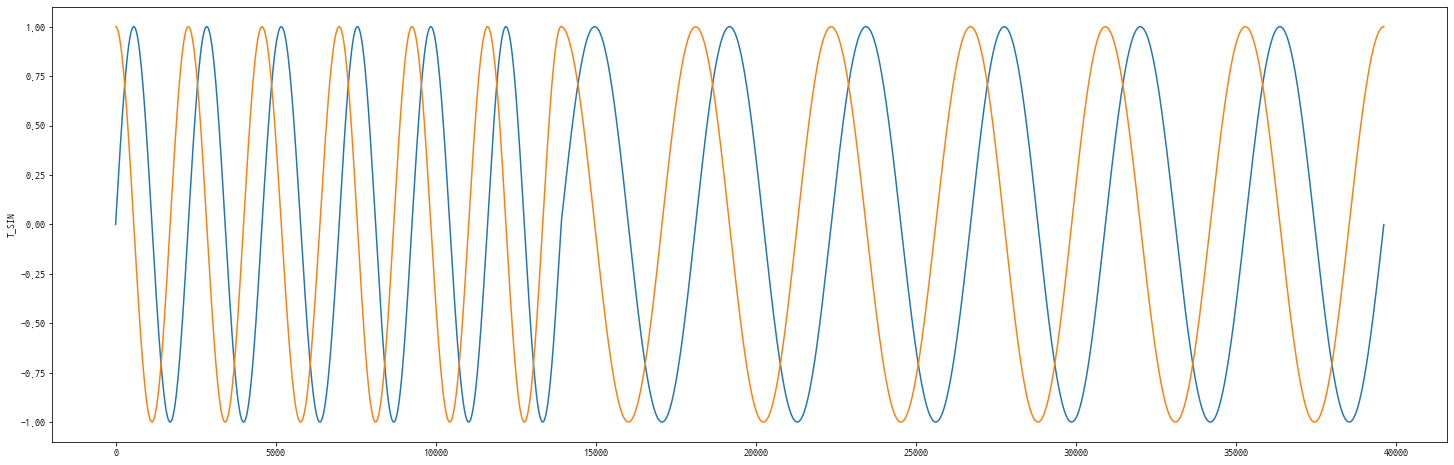

In [82]:
# plt.figure(figsize=(25,8))
# sns.lineplot(data=T, x=T.index, y='T_SIN')
# sns.lineplot(data=T, x=T.index, y='T_COS')
# plt.show()


In [9]:
s_idx, e_idx = train_index[0]
train = train_raw[s_idx:e_idx].copy()
len(outlier_index(data=train['Y_01'].abs(), sigma=2))

671

## 학습 및 예측(평가)

In [26]:
is_vaildation = False
result_list = []

for patten_i, (s_idx, e_idx) in enumerate(train_index):
  train = train_raw[s_idx:e_idx].copy()
  result = defaultdict(list)
  for cname in ['Y_%02d' % (i+1) for i in range(14)]: 
    print(cname)
    # X, y 선언
    # filter_data = train.drop(index=outlier_index(data=train[cname].abs(), sigma=2)).copy()
    # print('Remove outlier: {}'.format(len(train) - len(filter_data)))
    # X = filter_data.filter(regex='X|T').copy()
    # y = filter_data[[cname]].values.ravel().copy()

    data = train.copy()
    X = data.filter(regex='X|T').copy()
    y = winsorize_value(data=data[[cname]])

    
    # 전처리 및 컬럼선택 파이프라인 작성

    lst_cols = ['X_07', 'X_08', 'X_09', 'X_49']
    # lst_cols = ['X_49']
    std_cols = sorted(list(set(X.columns) - set(lst_cols)))

    log_transformer = Pipeline(steps=[
        ("log1p", FunctionTransformer(np.log1p))
    ])

    splitrans = ColumnTransformer(transformers=[
        ("lst", log_transformer, lst_cols),
        ("none", 'passthrough', std_cols)
    ])

    preprocessing = Pipeline(steps=[    
        ("split", splitrans),
        ('minmax', MinMaxScaler())
    ])

    Xt = preprocessing.fit_transform(X)
    Xt = pd.DataFrame(data=Xt, columns=lst_cols + std_cols)

    # Estimater 선언
    rf_reg = RandomForestRegressor(criterion="squared_error"
                        , random_state=13, n_jobs=4
                        , n_estimators=400
                        , max_depth=80
                        , min_samples_leaf=2
                        , min_samples_split=2
                        , warm_start=True)
    
    # 컬럼선택
    select_pipe = Pipeline(steps=[
      # ('preprocessing', preprocessing),
      ('feature_selection', SelectFromModel(estimator=rf_reg, max_features=25))
    ])

    select_pipe.fit(Xt, y)
    selector = select_pipe['feature_selection']
    selected_columns = pd.Index(Xt.columns)
    selected_columns = selected_columns[selector.get_support()]
    print('selected_columns: {}'.format(selected_columns))

    Xt = Xt.filter(items=selected_columns).copy()

    # 학습하기
    # 전처리 및 Estimater 파이프라인 작성
    estimate_pipe = Pipeline(steps=[
      # ('preprocessing', preprocessing),
      ('regression', rf_reg)
    ])

    # 평가모드
    if is_vaildation:
      kfold = KFold(n_splits=6, shuffle=False)
      scores = cross_val_score(estimate_pipe, Xt, y, cv=kfold
                      , scoring=make_scorer(single_nrmse
                                            , greater_is_better=False)
                      , verbose=3)
      print('{} score: {}'.format(cname, np.mean(scores)))
      result[cname].append(np.mean(scores))

    # 결과파일생성
    else:
      estimate_pipe.fit(Xt, y)

      print('Test data loads...')
      s_idx, e_idx = test_index[patten_i]
      X = test_raw.filter(regex='X|T').copy()
      X = X[s_idx:e_idx].copy()
      

      # 테스트데이터 전처리
      Xt = preprocessing.fit_transform(X)
      Xt = pd.DataFrame(data=Xt, columns=lst_cols + std_cols, index=X.index)
      Xt = Xt.filter(items=selected_columns).copy()

      # 결과 예측 및 저장            
      y_pred = estimate_pipe.predict(Xt)
      result[cname] = y_pred

  if is_vaildation:
    result_list.append(pd.DataFrame(result))
  else:
    result_list.append(pd.DataFrame(result, index=Xt.index))

Y_01
selected_columns: Index(['X_07', 'X_08', 'X_09', 'X_49', 'T_COS', 'T_SIN', 'X_03', 'X_05',
       'X_19', 'X_20', 'X_21', 'X_22', 'X_34', 'X_35', 'X_36', 'X_37', 'X_43'],
      dtype='object')
Test data loads...
Y_02
selected_columns: Index(['X_07', 'X_08', 'X_09', 'X_49', 'T_COS', 'T_SIN', 'X_03', 'X_05',
       'X_19', 'X_20', 'X_21', 'X_22', 'X_33', 'X_34', 'X_35', 'X_36', 'X_37',
       'X_43'],
      dtype='object')
Test data loads...
Y_03
selected_columns: Index(['X_07', 'X_08', 'X_09', 'X_49', 'T_COS', 'T_SIN', 'X_03', 'X_05',
       'X_19', 'X_20', 'X_21', 'X_22', 'X_34', 'X_35', 'X_36', 'X_37', 'X_43'],
      dtype='object')
Test data loads...
Y_04
selected_columns: Index(['X_07', 'X_08', 'X_09', 'X_49', 'T_COS', 'T_SIN', 'X_03', 'X_05',
       'X_19', 'X_21', 'X_22', 'X_31', 'X_37'],
      dtype='object')
Test data loads...
Y_05
selected_columns: Index(['X_07', 'X_08', 'X_09', 'X_49', 'T_COS', 'T_SIN', 'X_03', 'X_05',
       'X_13', 'X_19', 'X_20', 'X_21', 'X_22', 'X_34'

In [ ]:
X.head()

,X_07,X_08,X_09,X_49,X_03,X_05,X_19,X_20,X_21,X_22,...,X_35,X_36,X_37,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,29.45,62.38,245.71,9706.03,67.47,101.892,3.11,3.17,3.06,3.13,...,12.88,12.89,12.99,137.043591,135.359219,147.837968,134.313475,125.605427,136.721425,125.028256
1,28.73,61.23,233.61,10423.43,65.17,101.944,2.97,3.11,2.91,3.20,...,12.87,12.89,12.93,133.736691,135.979817,149.924692,123.630583,127.893337,143.322659,124.877308
2,28.81,105.77,272.20,10948.53,64.07,103.153,3.04,3.04,3.01,3.12,...,12.87,12.87,13.00,132.805112,131.055355,146.814592,128.939070,127.012195,140.395688,122.238232
3,28.92,115.21,255.36,15007.03,67.57,101.971,3.05,3.01,3.02,3.08,...,12.97,12.99,12.92,134.138760,133.239422,139.720132,132.260824,130.723186,147.624829,134.875225
4,29.68,103.38,241.46,11051.03,63.57,101.981,3.04,3.07,3.00,3.12,...,12.85,12.91,12.96,142.728970,136.620022,134.853555,134.760252,125.647793,139.331105,123.272762


In [ ]:
without_50

,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,-0.266443,-0.352843,-0.350717,-0.174724,-0.081436,-0.045968,-0.136826,-0.025584,-0.025382,-0.041862,-0.033456,-0.025435,-0.025491,-0.025510
0,-0.250203,-0.360817,-0.349778,-0.196842,-0.078676,-0.046184,-0.125057,-0.022631,-0.022455,-0.035553,-0.032936,-0.022621,-0.022500,-0.022555


In [ ]:
best = preds.copy()
best

,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,-0.265250,-0.350668,-0.349440,-0.167307,-0.079774,-0.044923,-0.134964,-0.025098,-0.024907,-0.041162,-0.032699,-0.024984,-0.025022,-0.025032
0,-0.248051,-0.358574,-0.347236,-0.192101,-0.077099,-0.044820,-0.123571,-0.022021,-0.021807,-0.034224,-0.032035,-0.022003,-0.021866,-0.021937


In [27]:
preds = pd.concat(result_list)
preds.head()

,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,1.478344,1.137419,1.102988,15.244771,31.478365,16.938944,3.217696,-25.667957,-25.711173,-21.964674,24.798111,-25.665641,-25.690349,-25.696104
1,1.424106,1.108139,1.006085,14.427980,31.815584,16.982799,3.123539,-25.567653,-25.631263,-21.939755,24.869553,-25.575265,-25.559472,-25.551045
2,1.443769,1.126519,1.125586,14.259270,31.745076,17.170366,3.076983,-25.553710,-25.645142,-21.885820,24.789932,-25.560409,-25.558563,-25.590810
3,1.456150,1.149229,1.055296,14.304677,32.116642,17.118664,3.005030,-25.667984,-25.748091,-21.852517,24.845815,-25.624436,-25.604095,-25.655456
4,1.536232,1.147976,1.236259,15.631042,31.760427,16.887197,3.075456,-25.848258,-25.844623,-22.112819,24.591111,-25.852269,-25.875263,-25.814836


In [85]:
best - preds

,Y_01,Y_02,Y_03,Y_04,Y_07
0,-0.000338,-0.000521,-0.000704,-0.001878,-0.001065
0,0.003368,0.003628,0.003296,0.007070,0.002163


In [19]:
best = preds.copy()
best

,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07
0,-0.219785,-0.302476,-0.299798,-0.153444,-0.068412,-0.038745,-0.118140
0,-0.214215,-0.321295,-0.308286,-0.170057,-0.067678,-0.037260,-0.110549


In [86]:
t_best = preds.copy()
t_best

,Y_01,Y_02,Y_03,Y_04,Y_07
0,-0.264935,-0.350221,-0.348790,-0.165448,-0.133920
0,-0.251419,-0.362202,-0.350533,-0.199172,-0.125735


In [28]:
preds.tail()

,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
39603,1.317179,0.972920,0.950127,13.884723,31.382788,16.826264,3.191177,-26.329541,-26.359843,-22.972648,24.478802,-26.272653,-26.240420,-26.312635
39604,1.311300,0.905260,0.922989,14.507064,31.517161,16.629581,3.209460,-26.472886,-26.445945,-23.064638,24.378941,-26.473357,-26.480922,-26.440800
39605,1.323565,0.906450,0.941349,13.429794,31.074278,16.848779,3.214973,-26.326102,-26.312734,-22.999354,24.567280,-26.305020,-26.269791,-26.351820
39606,1.431888,1.024311,1.054916,13.028828,31.191255,16.553811,3.200311,-26.442210,-26.390630,-23.255403,24.166349,-26.376923,-26.343882,-26.413546
39607,1.322296,1.016078,1.069520,12.182889,31.334887,16.469309,3.251410,-26.456770,-26.394437,-23.014371,24.170819,-26.418094,-26.376948,-26.391766


In [29]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39608 entries, 0 to 39607
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y_01    39608 non-null  float64
 1   Y_02    39608 non-null  float64
 2   Y_03    39608 non-null  float64
 3   Y_04    39608 non-null  float64
 4   Y_05    39608 non-null  float64
 5   Y_06    39608 non-null  float64
 6   Y_07    39608 non-null  float64
 7   Y_08    39608 non-null  float64
 8   Y_09    39608 non-null  float64
 9   Y_10    39608 non-null  float64
 10  Y_11    39608 non-null  float64
 11  Y_12    39608 non-null  float64
 12  Y_13    39608 non-null  float64
 13  Y_14    39608 non-null  float64
dtypes: float64(14)
memory usage: 4.2 MB


## 결과파일 작성

In [30]:
preds = preds.values

submit = raw_data['sample_submission'].copy()
for idx, col in enumerate(submit.columns):
  if col=='ID':
      continue
  submit[col] = preds[:,idx-1]
print('Done.')

submit.to_csv('/content/submit.csv', index=False)
print('Done.')

Done.
Done.


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
!cp './submit.csv' '/content/drive/MyDrive/DeepLearning_Datas'